# Multi-Factor Models

The first part of this notebook summarizes a simple economic model that leads to a multi-factor representation of the expected returns. The second part tests a multi-factor model by OLS.

## Load Packages and Extra Functions

In [1]:
using Printf, DelimitedFiles, Statistics, LinearAlgebra

include("src/printmat.jl")
include("src/OlsGMFn.jl");             #funtcion for doing OLS

In [2]:
using Plots, LaTeXStrings
default(size = (480,320),fmt = :png)

# Portfolio Choice with Background Risk

The investor maximizes
$\text{E}R_{p}-\frac{k}{2}\text{Var}(R_{p})$, where 

$R_{p} = (1-\phi) R_{Fin} + \phi R_{c}$ with $R_{Fin} = w^{\prime}R+(1-\mathbf{1}^{\prime}w) R_{f}$.

In this definition of the portfolio return, $\phi$ is the fraction of total wealth that is bound to non-traded "assets": this is the background risk.

Notice that $\text{E}R_{p} = v'\mu^e + \phi \mu_c^e + R_f$, where $v = w(1-\phi)$ and where $\mu^e$ is the vector of excess returns on the risky assets and $\mu_c^e$ is the excess return on the background risk. Also, $\text{Var}(R_{p}) = v'\Sigma v + \phi^2 \sigma_{cc} + 2\phi v'S_c,$ where 
$S_{c}$ is a vector of covariances of the risky assets with the background risk,
and $\sigma_{cc}$ is the variance of the background risk.

The next cell defined functions for expected utility and the optimal portfolio choice.

### A Remark on the Code

The code uses the subscript $h$ (as in $S_h$ etc) instead of $c$. The reason is that the Julia unicode symbols do not include a subscripted `c`.

In [3]:
"""
    EU

Expected utility for the case with background risk.

The notation follows the text above, except that the subscript h (as in Sₕ) for the non-traded asset, since c is not defined as a subscript in Julia.
"""
function EU(v,ϕ,k,μᵉ,Σ,Sₕ,σₕₕ,μᵉₕ,Rf)
    ERp   = v'μᵉ + ϕ*μᵉₕ + Rf
    VarRp = v'*Σ*v + ϕ^2*σₕₕ + 2*ϕ*v'*Sₕ
    EUtil = ERp - k/2*VarRp
    return EUtil
end

"""
    PortFOpt

Solve for the optimal weight on risky asset (v), ϕ in non-traded asset (background risk), 1-v-ϕ in Rf.

The notation follows the text above.
"""
function PortFOpt(ϕ,k,μᵉ,Σ,Sₕ)
    vopt  = inv(Σ)*(μᵉ/k-ϕ*Sₕ)
    wopt  = vopt/(1-ϕ)          #weight on risky in financial subportfolio
    return vopt, wopt
end

PortFOpt

## One Risky Asset

We first consider the case when there is only one risky asset ($v$ is a scalar). We will illustrate several cases ($A,B,C$) which differ with respect to the fraction of non-traded asset (denoted $\phi$) and its covariance with the risk assets (denoted $S_c$ as in the lecture notes or $S_h$ as in the code).

In [4]:
Σ    = 0.08^2                 #covariance (matrix) of risky assets, here only one
Sₕ_A = 0                      #covariance(s) of risky with background, case A
Sₕ_C = 0.0025                 #case C
(μᵉ,k,σₕₕ,μᵉₕ,Rf) = (0.065,25,0.01,0.02,0.03)

v_range = range(-0.5,1,length=51)  #weight on risky investable asset
L       = length(v_range)

                                     #expected utility at different v values
(EU_case_A,EU_case_B,EU_case_C) = (fill(NaN,L),fill(NaN,L),fill(NaN,L))
for i in 1:L
    EU_case_A[i] = EU(v_range[i],0,k,μᵉ,Σ,Sₕ_A,σₕₕ,μᵉₕ,Rf)     #ϕ=0
    EU_case_B[i] = EU(v_range[i],0.5,k,μᵉ,Σ,Sₕ_A,σₕₕ,μᵉₕ,Rf)   #ϕ>0, Sₕ=0
    EU_case_C[i] = EU(v_range[i],0.5,k,μᵉ,Σ,Sₕ_C,σₕₕ,μᵉₕ,Rf)   #ϕ>0, Sₕ>0
end

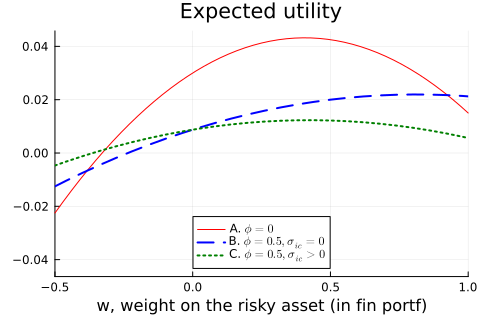

In [5]:
p1 = plot( [v_range v_range/(1-0.5) v_range/(1-0.5)],[EU_case_A EU_case_B EU_case_C],
           linecolor = [:red :blue :green],
           linestyle = [:solid :dash :dot],
           linewidth = [1 2 2],
           label = [L"A. $\phi=0$" L"B. $\phi=0.5, \sigma_{ic}=0 $" L"C. $\phi=0.5, \sigma_{ic}>0$"],
           xlims = (-0.5,1),
           legend = :bottom,
           title = "Expected utility",
           xlabel = "w, weight on the risky asset (in fin portf)" )
display(p1)

In [6]:
(v_A,w_A) = PortFOpt(0,k,μᵉ,Σ,Sₕ_A)               #optimal portfolio choice
(v_B,w_B) = PortFOpt(0.5,k,μᵉ,Σ,Sₕ_A)
(v_C,w_C) = PortFOpt(0.5,k,μᵉ,Σ,Sₕ_C)

printblue("\nOptimal weight on (a single) risky asset in three cases (ϕ >= 0):\n")
xx = [v_A w_A;v_B w_B;v_C w_C]
colNames = ["in total portf","in financial portf"]
rowNames = ["A. ϕ=0","B. ϕ=0.5, σᵢₕ=0","C. ϕ=0.5, σᵢₕ>0"]
printmat(xx;colNames,rowNames,width=20)

printred("\nCompare with the plot")


Optimal weight on (a single) risky asset in three cases (ϕ >= 0):

                     in total portf  in financial portf
A. ϕ=0                        0.406               0.406
B. ϕ=0.5, σᵢₕ=0               0.406               0.812
C. ϕ=0.5, σᵢₕ>0               0.211               0.422


Compare with the plot


## Several Risky Assets

We now consider several risky assets. Notice that $S_c$ (or $S_h$) is now a vector of covariances of each of the investable risky assets with the non-traded asset.

### A Remark on the Code
- The $S_h$ vector is here created in such a way that we prespecify the correlations (and then scale with the product of the standard deviations of the non-traded assets and the risky assets).

In [7]:
μ = [11.5, 9.5, 6]/100          #expected returns
Σ = [166  34  58;               #covariance matrix
      34  64   4;
      58   4 100]/100^2
Rf = 0.03

ϕ   = 0.3                            #fraction of non-traded asset
σₕₕ = 0.25^2
Sₕ  = [0.5,0.9,-0.1].*sqrt(σₕₕ).*sqrt.(diag(Σ))  #a vector of covariances
μₕ  = 0.1
k   = 8

(v,w) = PortFOpt(ϕ,k,μ.-Rf,Σ,Sₕ)

printblue("optimal weights (inside the financial subportfolio):\n")
printmat([w;1-sum(w)],rowNames=["A","B","C","Rf"])

optimal weights (inside the financial subportfolio):

A      0.235
B      0.453
C      0.488
Rf    -0.176



# Asset Pricing Implications of a Multifactor Model

If several factors affect the portfolio choice, then they will (in equilibrium) also affect prices and returns. In fact, the expected excess return on asset $i$ is

$\mathrm{E}R^e_i = \beta_i'\mu^e_F$,

where $\beta_i$ is the vector of regressions coefficients from regressing $R^e_i$ on the factors and $\mu^e_F$ is the vector of expected excess returns on those factors.

The example below assumes there are two factors and we only consider the pricing of a single investable asset. The numbers used have nothing in particular to do with those used in the previous examples. (That link could be done, but requires some intermdiate steps that we here skip.)

### Remark
A vector of regression slopes ($y$ regressed on the vector $x$) can be calculated as

$\beta = \Sigma_{xx}^{-1} S_{xy}$,

where $\Sigma_{xx}$ is the variance-covariance matrix of $x$ and $S_{xy}$ is a vector of covariance of each $x$ with $y$.

In [8]:
μᵉF = [0.08,0.06]            #avg. excess returns of factors

Ψ = [1 0.5;                  #covariance matrix of the factors
     0.5 2]
Sᵢ = [0.5,0.7]               #Cov(Ri,factor1) and Cov(Ri,factor2)

β = inv(Ψ)*Sᵢ                #coeffs in ERᵉ = β'Factors
printlnPs("The multiple regression coefficients: ")
printmat(β)

μᵉ = β'μᵉF
printlnPs("μᵉ for asset i according to 2-factor model:")
printmat(μᵉ)

The multiple regression coefficients: 
     0.371
     0.257

μᵉ for asset i according to 2-factor model:
     0.045



# Empirical Test of a 3-Factor Model: Loading Data

## Load Data

In [9]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1,7,13,19,25]]           #use just 5 assets to make the printing easier

(T,n) = size(Re)                    #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

Recall: estimate $(\alpha_{i},b_{i})$ in the factor model

$R_{it}^{e}  =\alpha_{i}+b_{i}'f_{t} + \varepsilon_{it}$,

where $f_t$ is a vector of excess returns of the factors.

Test if $\alpha_{i}=0$

In [10]:
x = [ones(T) Rme RSMB RHML]         #regressors

(α,tstat) = (fill(NaN,n),fill(NaN,n))
for i in 1:n                              #loop over the different test assets
    #local b_i,Covb                      #local/global is needed in script
    (b_i,_,_,Covb,_) = OlsGMFn(Re[:,i],x)
    α[i]      = b_i[1]
    tstat[i] = (α[i]-0)/sqrt(Covb[1,1])  #t-stat for α[i]=0?
end

printblue("Regression of Re on constant and 3 factors:\n")
colNames = [string("asset ",i) for i=1:n]
printmat([α';tstat'];colNames,rowNames=["α","t-stat"])

Regression of Re on constant and 3 factors:

         asset 1   asset 2   asset 3   asset 4   asset 5
α         -0.513    -0.006     0.030    -0.020    -0.015
t-stat    -2.306    -0.066     0.328    -0.206    -0.133

